In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier


In [2]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.inference
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.inference)
importlib.reload(endoutbreakvbd.utils)
importlib.reload(endoutbreakvbd)

from endoutbreakvbd import eop_analytical, eop_simulation
from endoutbreakvbd.chikungunya import get_data, get_parameters, get_weather_data
from endoutbreakvbd.inference import fit_random_walk_model, fit_weather_model
from endoutbreakvbd.utils import month_start_xticks

In [3]:
df = get_data()
df_weather = get_weather_data()
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]
rep_no_func = parameters["rep_no_func"]
rep_no_func_doy = parameters["rep_no_func_doy"]

rng = np.random.default_rng(2)

In [4]:
doy_start = df["doy"].to_numpy()[0]
incidence_vec = df["cases"].to_numpy()
doy_vec = np.arange(doy_start, doy_start + len(incidence_vec))
idata = fit_random_walk_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
)
rep_no_vec = idata.posterior["rep_no_vec"].mean(dim=["chain", "draw"]).to_numpy()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rep_no_start, rep_no_jumps]


Output()

/Users/user/Documents/Git_repos/end-of-outbreak-vbd/.pixi/envs/default/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


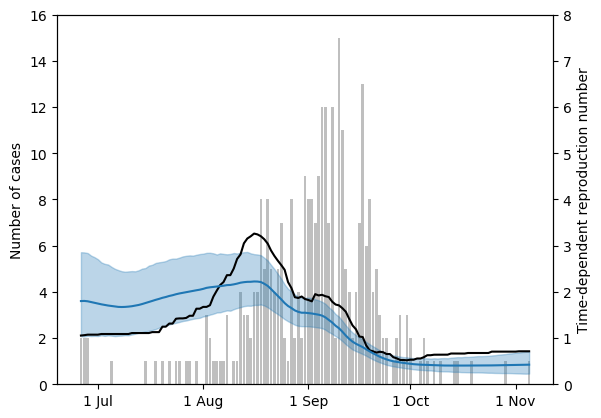

In [5]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.doy, df["cases"], color="gray", alpha=0.5)
ax2.plot(doy_vec, rep_no_func_doy(doy_vec), color="black")
ax2.plot(
    doy_vec,
    rep_no_vec,
    color="tab:blue",
)
ax2.fill_between(
    doy_vec,
    np.percentile(idata.posterior["rep_no_vec"].values, 2.5, axis=(0, 1)),
    np.percentile(idata.posterior["rep_no_vec"].values, 97.5, axis=(0, 1)),
    color="tab:blue",
    alpha=0.3,
)

month_start_xticks(ax, interval_months=1)
ax.set_ylim(0, 16)
ax2.set_ylim(0, 8)
ax.set_ylabel("Number of cases")
ax2.set_ylabel("Time-dependent reproduction number");

np.float64(0.9109870716571975)

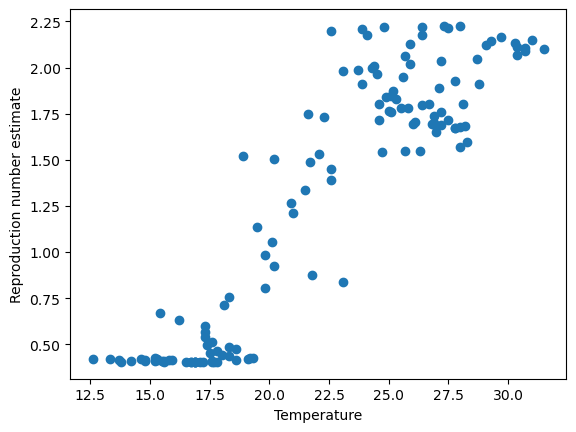

In [6]:
temperature_vec = (
    df_weather["temperature"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
fig, ax = plt.subplots()
ax.scatter(temperature_vec, rep_no_vec)
ax.set_xlabel("Temperature")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(temperature_vec, rep_no_vec)[0, 1]

np.float64(0.9750719810193909)

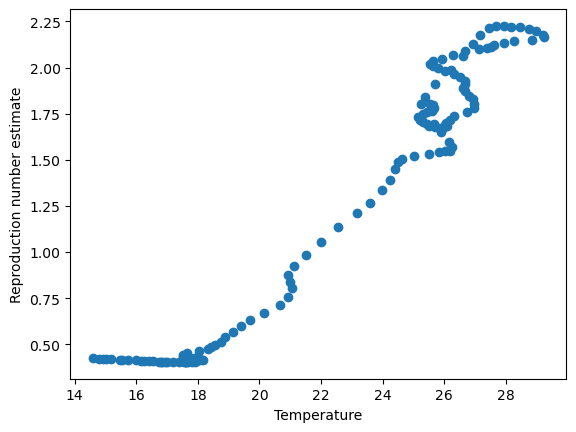

In [21]:
window = 14
df_weather_rolling = (
    df_weather[["temperature"]].rolling(window=window, center=False).mean()
)
df_weather_rolling["doy"] = df_weather_rolling.index.dayofyear
temperature_vec_rolling = (
    df_weather_rolling["temperature"]
    .loc[df_weather_rolling["doy"].isin(doy_vec)]
    .to_numpy()
)
fig, ax = plt.subplots()
ax.scatter(temperature_vec_rolling, rep_no_vec)
ax.set_xlabel("Temperature")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(temperature_vec_rolling, rep_no_vec)[0, 1]

np.float64(0.9300203243976853)

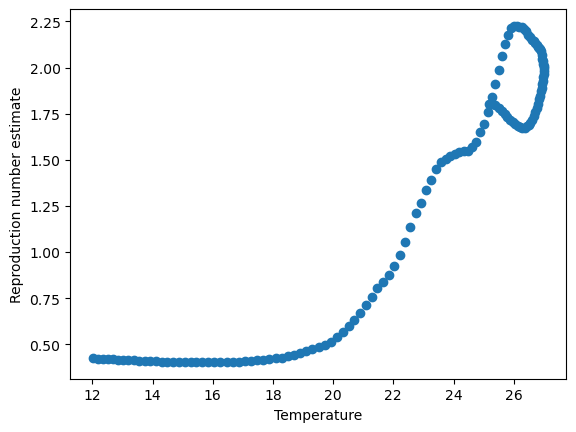

In [40]:
dp = DeterministicProcess(
    index=df_weather.index,
    constant=True,
    additional_terms=[Fourier(order=2, period=365)],
    drop=True,
)
X = dp.in_sample()  # DataFrame with sin/cos columns + intercept
y = df_weather["temperature"].loc[X.index]
model = OLS(y, X).fit()
df_weather_smoothed = pd.DataFrame(
    {"doy": X.index.dayofyear, "temperature": model.fittedvalues},
    index=X.index,
)
temperature_vec_smoothed = (
    df_weather_smoothed["temperature"]
    .loc[df_weather_smoothed["doy"].isin(doy_vec)]
    .to_numpy()
)
fig, ax = plt.subplots()
ax.scatter(temperature_vec_smoothed, rep_no_vec)
ax.set_xlabel("Temperature")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(temperature_vec_smoothed, rep_no_vec)[0, 1]

In [36]:
import scipy.interpolate
from climepi import epimod

suitability_model = epimod.get_example_model("mordecai_ae_albopictus_suitability")
temp_grid = suitability_model.suitability_table["temperature"].values
suitability_grid = suitability_model.suitability_table["suitability"].values

suitability_vec = scipy.interpolate.interp1d(
    temp_grid, suitability_grid, bounds_error=False, fill_value=0.0
)(temperature_vec)
suitability_vec_rolling = scipy.interpolate.interp1d(
    temp_grid, suitability_grid, bounds_error=False, fill_value=0.0
)(temperature_vec_rolling)
suitability_vec_smoothed = scipy.interpolate.interp1d(
    temp_grid, suitability_grid, bounds_error=False, fill_value=0.0
)(temperature_vec_smoothed)

# suitability_vec = suitability_model.run(
#     df_weather.loc[df_weather["doy"].isin(doy_vec)][["temperature"]]
#     .to_xarray()
#     .rename(date="time")
# )["suitability"].values
# suitability_vec_rolling = suitability_model.run(
#     df_weather_rolling.loc[df_weather_rolling["doy"].isin(doy_vec)][["temperature"]]
#     .to_xarray()
#     .rename(date="time")
# )["suitability"].values
# suitability_vec_smoothed = suitability_model.run(
#     df_weather_smoothed.loc[df_weather_smoothed["doy"].isin(doy_vec)][["temperature"]]
#     .to_xarray()
#     .rename(date="time")
# )["suitability"].values

np.float64(0.811461903089032)

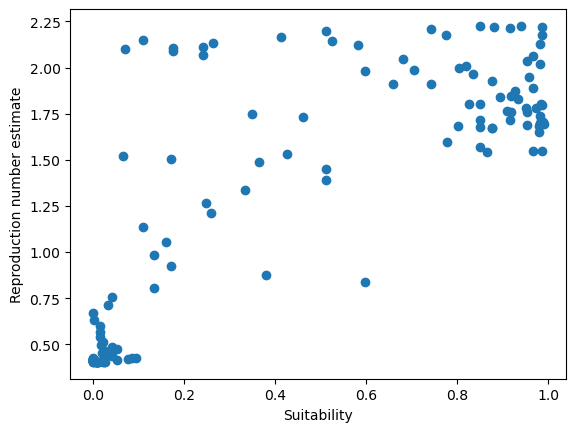

In [37]:
fig, ax = plt.subplots()
ax.scatter(suitability_vec, rep_no_vec)
ax.set_xlabel("Suitability")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(suitability_vec, rep_no_vec)[0, 1]

np.float64(0.9359588299921373)

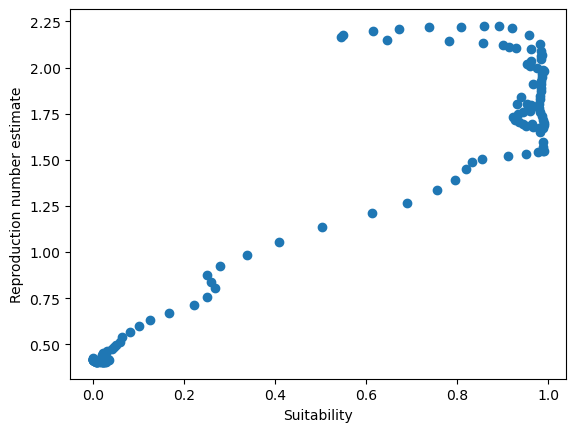

In [38]:
fig, ax = plt.subplots()
ax.scatter(suitability_vec_rolling, rep_no_vec)
ax.set_xlabel("Suitability")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(suitability_vec_rolling, rep_no_vec)[0, 1]

np.float64(0.9812941743645741)

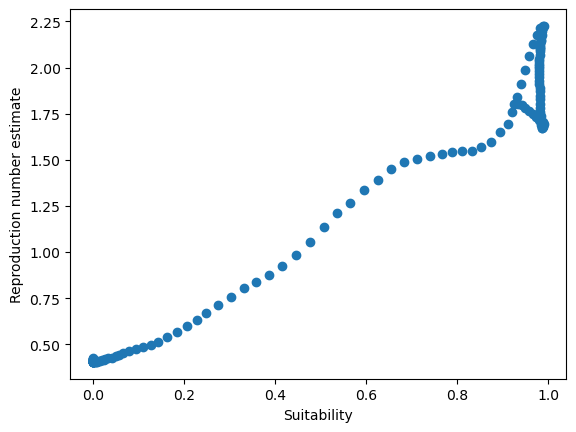

In [39]:
fig, ax = plt.subplots()
ax.scatter(suitability_vec_smoothed, rep_no_vec)
ax.set_xlabel("Suitability")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(suitability_vec_smoothed, rep_no_vec)[0, 1]